「RとStanで始めるベイズ統計モデリングによるデータ分析入門」「実践編第5部第5章 トレンドの構造」を対象に，公開されているR，Stanのコードをpython，pystanのコードへと書き直した一例です。Stanの代わりにpystanを利用しています。

本ページでは公開されていない書籍の内容については一切触れません。理論や詳しい説明は書籍を参照してください。

なお，こちらで紹介しているコードには誤りが含まれる可能性があります。内容やコードについてお気づきの点等ございましたら，ご指摘いただけると幸いです。

# 分析の準備
## パッケージの読み込み

In [1]:
import arviz
import pystan
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Meiryo'

# データの読み込みと図示
## データの読み込み

In [2]:
sales_df_3 = pd.read_csv('5-5-1-sales-ts-3.csv')
sales_df_3['date'] = pd.to_datetime(sales_df_3['date'])
sales_df_3.head(n=3)

,date,sales
0,2010-01-01,93.5
1,2010-01-02,81.9
2,2010-01-03,91.0


## 図示

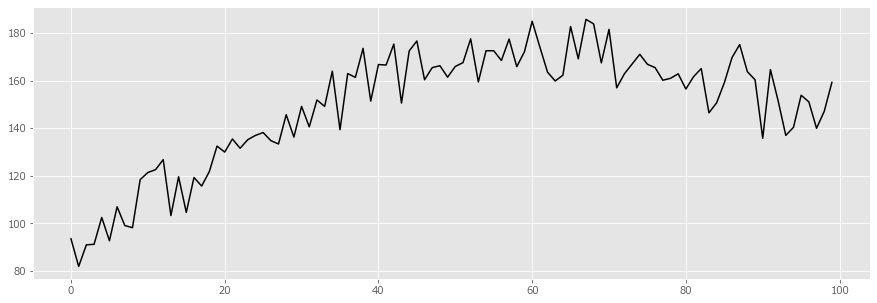

In [3]:
plt.figure(figsize=(15,5))
plt.plot(sales_df_3['sales'].values, color='black')
plt.show()

# ローカルレベルモデルの推定
## データの準備

In [4]:
data_list = dict(y=sales_df_3['sales'], T=len(sales_df_3))

## ローカルレベルモデルの推定

In [5]:
# stanコードの記述
stan_code = '''
data {
  int T;         // データ取得期間の長さ
  vector[T] y;   // 観測値
}

parameters {
  vector[T] mu;       // 状態の推定値(水準成分)
  real<lower=0> s_w;  // 過程誤差の標準偏差
  real<lower=0> s_v;  // 観測誤差の標準偏差
}

model {
  // 状態方程式に従い、状態が遷移する
  for(i in 2:T) {
    mu[i] ~ normal(mu[i-1], s_w);
  }
  
  // 観測方程式に従い、観測値が得られる
  for(i in 1:T) {
    y[i] ~ normal(mu[i], s_v);
  }
}

'''

# モデルのコンパイル
stan_model_ll = pystan.StanModel(model_code=stan_code)

# サンプリング
local_level = stan_model_ll.sampling(data=data_list, seed=1, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5912d60dc72bb8ffe174964dc2cf39dd NOW.


## ローカルレベルモデルの推定結果

In [6]:
print(local_level.stansummary(pars=['s_w', 's_v', 'lp__'],
                              probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_5912d60dc72bb8ffe174964dc2cf39dd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
s_w    4.27    0.04   0.83   2.94   4.18   6.12    477    1.0
s_v    7.58    0.01   0.72   6.21   7.56   9.09   2710    1.0
lp__ -438.7    0.72  14.66 -467.8 -438.6 -411.6    415    1.0

Samples were drawn using NUTS at Thu Sep  3 21:54:42 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# 平滑化トレンドモデルの推定
## 平滑化トレンドモデルの推定

In [7]:
# stanコードの記述
stan_code = '''
data {
  int T;        // データ取得期間の長さ
  vector[T] y;  // 観測値
}

parameters {
  vector[T] mu;       // 水準+ドリフト成分の推定値
  real<lower=0> s_z;  // ドリフト成分の変動の大きさを表す標準偏差
  real<lower=0> s_v;  // 観測誤差の標準偏差
}

model {
  // 状態方程式に従い、状態が遷移する
  for(i in 3:T) {
    mu[i] ~ normal(2 * mu[i-1] - mu[i-2], s_z);
  }
  
  // 観測方程式に従い、観測値が得られる
  for(i in 1:T) {
    y[i] ~ normal(mu[i], s_v);
  }

}

'''

# モデルのコンパイル
stan_model_st = pystan.StanModel(model_code=stan_code)

# サンプリング
smooth_trend = stan_model_st.sampling(data=data_list,
                                      seed=1,
                                      n_jobs=1,
                                      iter=8000,
                                      warmup=2000,
                                      thin=6,
                                      control={
                                          'adapt_delta': 0.9,
                                          'max_treedepth': 15
                                      })

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7270b55e94b176c72908fca84c5355ab NOW.


## 平滑化トレンドモデルの推定結果

In [8]:
print(smooth_trend.stansummary(pars=['s_z', 's_v', 'lp__'],
                               probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_7270b55e94b176c72908fca84c5355ab.
4 chains, each with iter=8000; warmup=2000; thin=6; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
s_z    0.26  6.4e-3   0.12   0.13   0.23   0.58    349   1.01
s_v    8.43    0.01   0.64   7.27   8.39    9.8   3891    1.0
lp__ -171.1    1.95  36.92 -256.2 -166.8 -110.2    357   1.01

Samples were drawn using NUTS at Thu Sep  3 22:05:50 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# ローカル線形トレンドモデルの推定
## ローカル線形トレンドモデルの推定

In [11]:
# stanコードの記述
stan_code = '''
data {
  int T;        // データ取得期間の長さ
  vector[T] y;  // 観測値
}

parameters {
  vector[T] mu;       // 水準+ドリフト成分の推定値
  vector[T] delta;    // ドリフト成分の推定値
  real<lower=0> s_w;  // 水準成分の変動の大きさを表す標準偏差
  real<lower=0> s_z;  // ドリフト成分の変動の大きさを表す標準偏差
  real<lower=0> s_v;  // 観測誤差の標準偏差
}

model {
  // 弱情報事前分布
  s_w ~ normal(2, 2);
  s_z ~ normal(0.5, 0.5);
  s_v ~ normal(10, 5);
  
  // 状態方程式に従い、状態が遷移する
  for(i in 2:T) {
    mu[i] ~ normal(mu[i-1] + delta[i-1], s_w);
    delta[i] ~ normal(delta[i-1], s_z);
  }
  
  // 観測方程式に従い、観測値が得られる
  for(i in 1:T) {
    y[i] ~ normal(mu[i], s_v);
  }

}

'''

# モデルのコンパイル
stan_model_llt = pystan.StanModel(model_code=stan_code)

# サンプリング
local_linear_trend = stan_model_llt.sampling(data=data_list,
                                            seed=1,
                                            n_jobs=1,
                                            iter=8000,
                                            warmup=2000,
                                            thin=6)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ddb0a2063558b071e59ccdc656993435 NOW.


## ローカル線形トレンドモデルの推定結果

In [12]:
print(local_linear_trend.stansummary(pars=['s_w', 's_z', 's_v', 'lp__'],
                                     probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_ddb0a2063558b071e59ccdc656993435.
4 chains, each with iter=8000; warmup=2000; thin=6; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
s_w    1.46    0.07   0.94   0.12    1.3   3.68    186   1.02
s_z    0.29  7.8e-3   0.13   0.13   0.26   0.63    293   1.01
s_v    8.29    0.02   0.66    7.1   8.26   9.63   1915    1.0
lp__ -235.7   11.45  89.63 -387.5 -246.1 -19.92     61   1.04

Samples were drawn using NUTS at Thu Sep  3 22:20:58 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


## 参考：収束の確認など

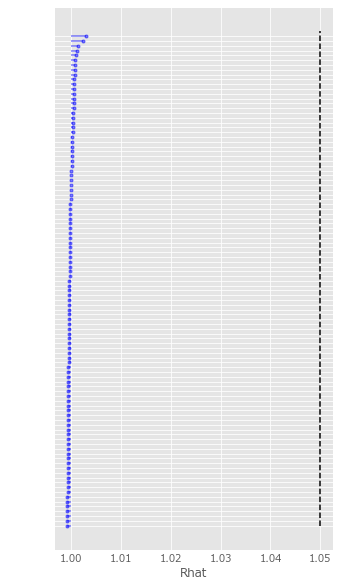

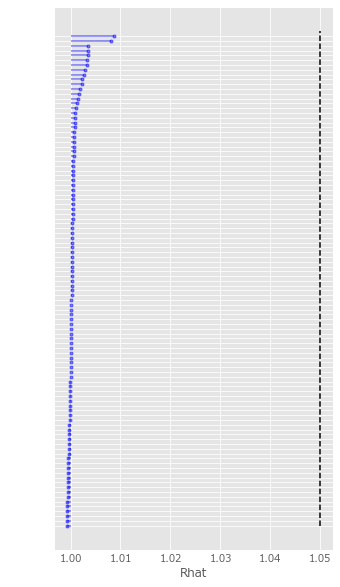

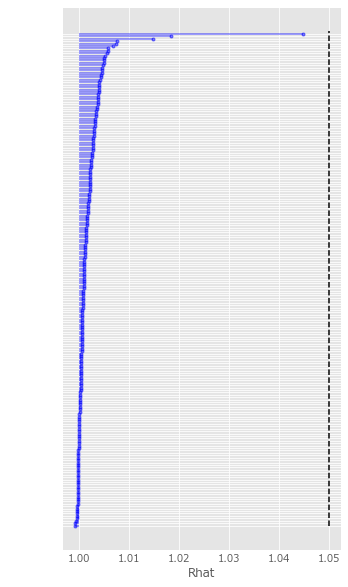

In [13]:
# 収束確認用のRhatのプロット関数
def mcmc_rhat(dataframe, column='Rhat', figsize=(5, 10)):
    plt.figure(figsize=figsize)
    plt.hlines(y=dataframe[column].sort_values().index,
               xmin=1,
               xmax=dataframe[column].sort_values(),
               color='b',
               alpha=0.5)
    plt.vlines(x=1.05, ymin=0, ymax=len(dataframe[column]), linestyles='--')
    plt.plot(dataframe[column].sort_values().values,
             dataframe[column].sort_values().index,
             marker='.',
             linestyle='None',
             color='b',
             alpha=0.5)
    plt.yticks(color='None')
    plt.tick_params(length=0)
    plt.xlabel(column)
    plt.show()


# 各推定結果のデータフレームを作成
summary_local = pd.DataFrame(local_level.summary()['summary'],
                             columns=local_level.summary()['summary_colnames'],
                             index=local_level.summary()['summary_rownames'])
summary_smooth = pd.DataFrame(smooth_trend.summary()['summary'],
                              columns=smooth_trend.summary()['summary_colnames'],
                              index=smooth_trend.summary()['summary_rownames'])
summary_linear = pd.DataFrame(local_linear_trend.summary()['summary'],
                              columns=local_linear_trend.summary()['summary_colnames'],
                              index=local_linear_trend.summary()['summary_rownames'])

# プロット
mcmc_rhat(summary_local)
mcmc_rhat(summary_smooth)
mcmc_rhat(summary_linear)

In [14]:
print('hmc_diagnostics of local_level:\n',pystan.diagnostics.check_hmc_diagnostics(local_level))
print('hmc_diagnostics of smooth_trend:\n',pystan.diagnostics.check_hmc_diagnostics(smooth_trend))
print('hmc_diagnostics of local_linear_trend:\n',pystan.diagnostics.check_hmc_diagnostics(local_linear_trend))

hmc_diagnostics of local_level:
 {'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}
hmc_diagnostics of smooth_trend:
 {'n_eff': True, 'Rhat': True, 'divergence': True, 'treedepth': True, 'energy': True}


hmc_diagnostics of local_linear_trend:
 {'n_eff': True, 'Rhat': True, 'divergence': False, 'treedepth': False, 'energy': False}


## 参考：推定結果一覧

In [15]:
print(local_level.stansummary(probs=[0.025, 0.5, 0.975]))
print(smooth_trend.stansummary(probs=[0.025, 0.5, 0.975]))
print(local_linear_trend.stansummary(probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_5912d60dc72bb8ffe174964dc2cf39dd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mu[1]    91.29    0.07   4.94  81.33  91.48 100.68   4999    1.0
mu[2]    90.39    0.08   4.45  81.42  90.47  98.81   3494    1.0
mu[3]    92.22    0.07   4.14  84.03   92.2 100.12   3884    1.0
mu[4]    94.27    0.06    4.0  86.64  94.24 102.24   4652    1.0
mu[5]    97.36    0.06   3.87  89.77  97.29 104.96   4753    1.0
mu[6]    98.55    0.06   3.92   90.8  98.51  106.3   3976    1.0
mu[7]   101.81    0.06   3.86  94.14 101.82 109.52   4805    1.0
mu[8]   103.36    0.06    3.9  95.56 103.36 110.92   4642    1.0
mu[9]   106.31    0.06   3.88  98.66 106.44 113.83   4520    1.0
mu[10]  112.02    0.06   3.96 104.47 111.93 120.03   4135    1.0
mu[11]  115.65    0.07   4.06 108.07  115.6 124.02   3680    1.0
mu[12]  117.38    0.07   4.04 1

Inference for Stan model: anon_model_ddb0a2063558b071e59ccdc656993435.
4 chains, each with iter=8000; warmup=2000; thin=6; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd    2.5%     50%  97.5%  n_eff   Rhat
mu[1]       88.34    0.14   4.54   79.42   88.27  97.22   1046    1.0
mu[2]       90.24    0.13   3.99   82.44   90.17  98.72    898    1.0
mu[3]       92.49    0.12   3.54   85.66   92.44  99.91    808    1.0
mu[4]       94.82    0.12   3.27   88.38    94.8 101.68    755   1.01
mu[5]       97.27    0.09   3.07   91.18   97.26 103.19   1240    1.0
mu[6]       99.44    0.08   2.98   93.36   99.43 105.13   1545    1.0
mu[7]      101.88    0.06    2.9   96.11  101.86 107.61   2148    1.0
mu[8]       104.1    0.06   2.87   98.16  104.07 109.75   1976    1.0
mu[9]      106.51    0.06   2.82  101.02   106.4 112.26   2059    1.0
mu[10]     109.26    0.08    3.0  103.83  108.99 115.57   1291    1.0
mu[11]     111.58     0.1   3.15  106.03 

## 参考：トレースプロット

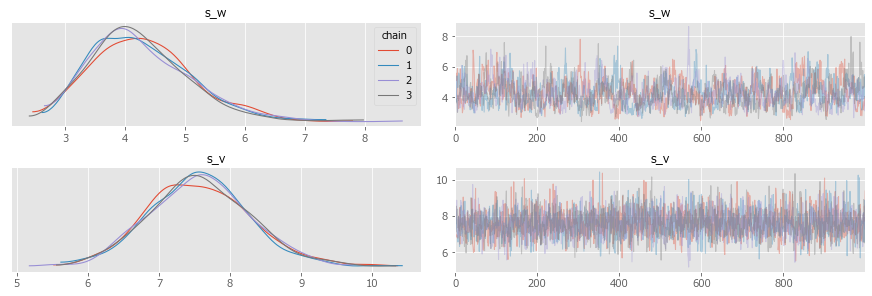

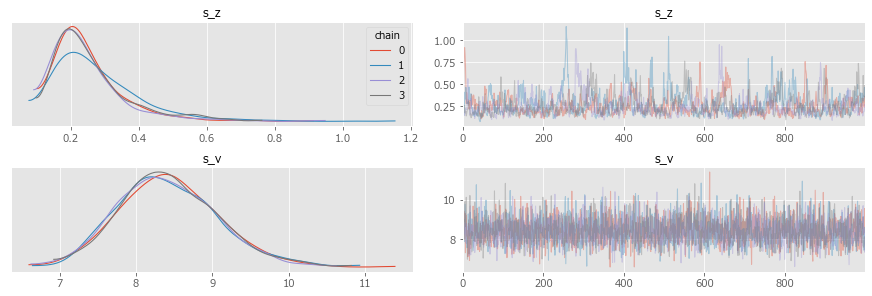

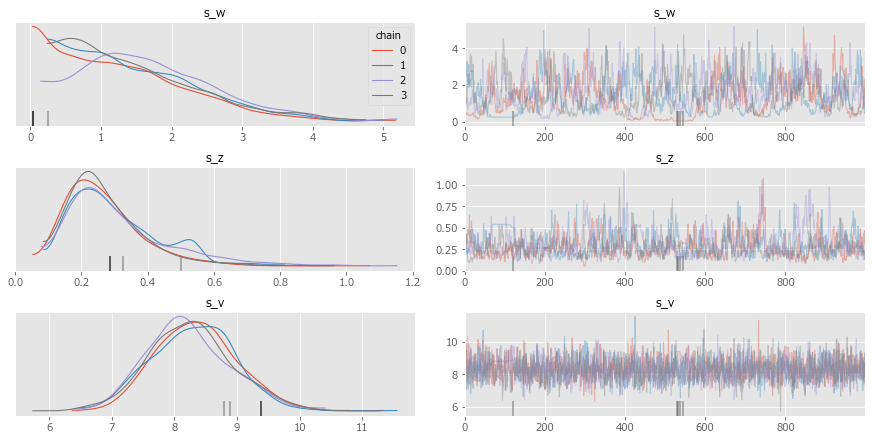

In [16]:
arviz.plot_trace(local_level,
                 var_names=['s_w', 's_v'],
                 legend=True);
arviz.plot_trace(smooth_trend,
                 var_names=['s_z', 's_v'],
                 legend=True);
arviz.plot_trace(local_linear_trend,
                 var_names=['s_w', 's_z', 's_v'],
                 legend=True);

# 推定された状態の図示

## MCMCサンプルの取得

In [17]:
mcmc_sample_ll = local_level.extract()
mcmc_sample_st = smooth_trend.extract()
mcmc_sample_llt = local_linear_trend.extract()

### 補足：全時刻の95%ベイズ信用区間と中央値

In [23]:
# パラメータを指定
state_name = 'mu'

# 2.5・50・97.5パーセンタイルの値を
# 入れるためのデータフレームを作成
result_ll = pd.DataFrame(np.zeros([len(sales_df_3), 3]))
result_st = pd.DataFrame(np.zeros([len(sales_df_3), 3]))
result_llt = pd.DataFrame(np.zeros([len(sales_df_3), 3]))

# 2.5・50・97.5パーセンタイルの値をデータフレームに格納
for i in range(len(sales_df_3)):
    result_ll.iloc[i, :] = np.percentile(mcmc_sample_ll[state_name][:, i],
                                         q=[2.5, 50, 97.5])
    result_st.iloc[i, :] = np.percentile(mcmc_sample_st[state_name][:, i],
                                         q=[2.5, 50, 97.5])
    result_llt.iloc[i, :] = np.percentile(mcmc_sample_llt[state_name][:, i],
                                          q=[2.5, 50, 97.5])

# 列名の変更
result_ll.columns = ["lwr", "fit", "upr"]
result_st.columns = ["lwr", "fit", "upr"]
result_llt.columns = ["lwr", "fit", "upr"]

# 時間情報の追加
result_ll['time'] = sales_df_3['date']
result_st['time'] = sales_df_3['date']
result_llt['time'] = sales_df_3['date']

# 実測値を追加
result_ll['obs'] = sales_df_3['sales']
result_st['obs'] = sales_df_3['sales']
result_llt['obs'] = sales_df_3['sales']

### 図示

C:\Users\rhira\Anaconda3\envs\multi\lib\site-packages\ipykernel_launcher.py:75: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


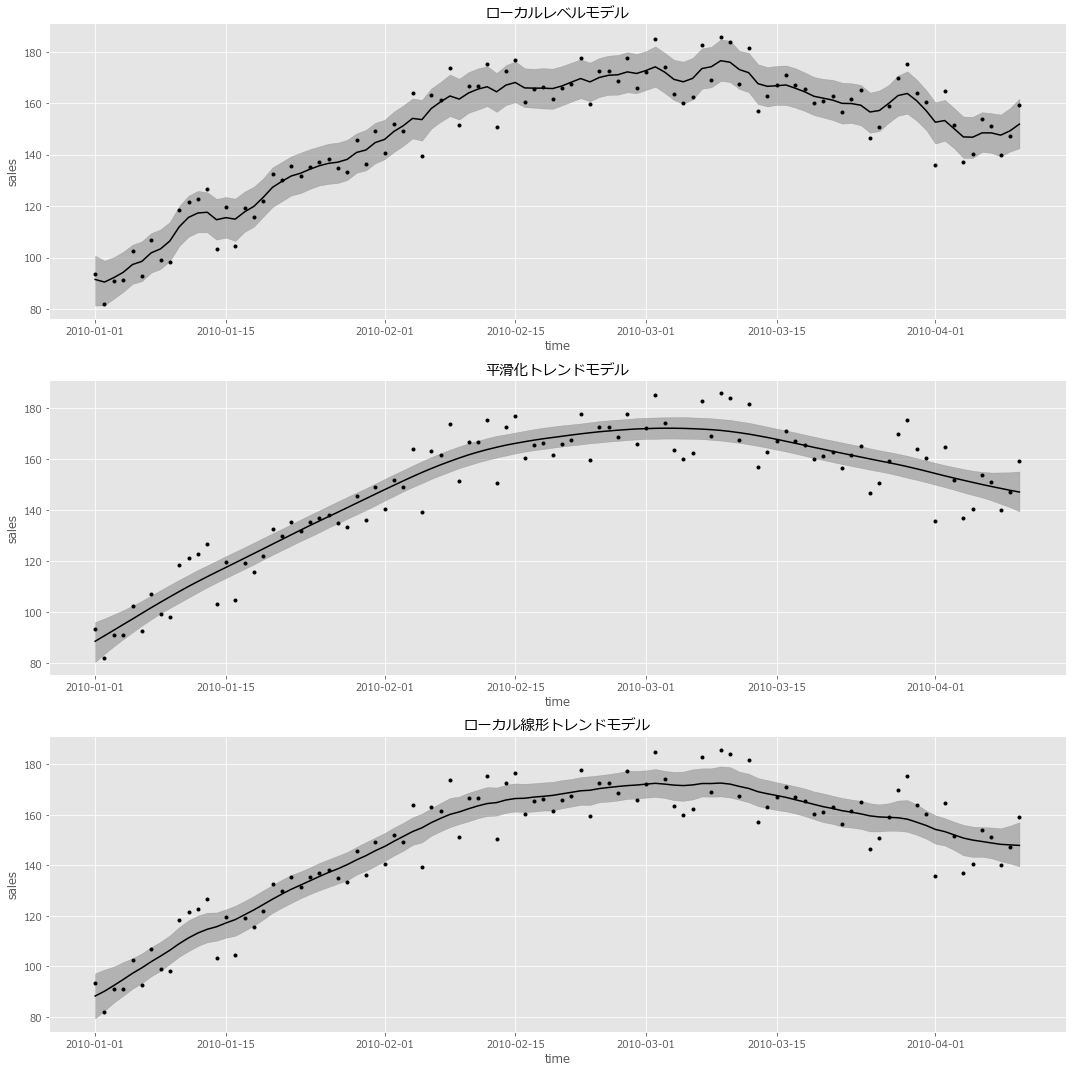

In [24]:
# 描画領域の作成
fig = plt.figure(figsize=(15, 15))

# ローカルレベルモデル
ax_ll = fig.add_subplot(3, 1, 1)
# 実測値をプロット
ax_ll.plot(result_ll['time'],
           result_ll['obs'],
           marker='.',
           linewidth=0,
           color='black')
# 50パーセンタイルの値をプロット
ax_ll.plot(result_ll['time'], result_ll['fit'], color='black')
# 2.5-97.5%区間の間を埋める
ax_ll.fill_between(x=result_ll['time'],
                   y1=result_ll['upr'],
                   y2=result_ll['lwr'],
                   color='gray',
                   alpha=0.5)
# x軸ラベルの設定
ax_ll.set_xlabel('time')
# y軸ラベルの設定
ax_ll.set_ylabel('sales')
# タイトルの設定
ax_ll.set_title('ローカルレベルモデル')

# 平滑化トレンドモデル
ax_st = fig.add_subplot(3, 1, 2)
# 実測値をプロット
ax_st.plot(result_st['time'],
           result_st['obs'],
           marker='.',
           linewidth=0,
           color='black')
# 50パーセンタイルの値をプロット
ax_st.plot(result_st['time'], result_st['fit'], color='black')
# 2.5-97.5%区間の間を埋める
ax_st.fill_between(x=result_st['time'],
                   y1=result_st['upr'],
                   y2=result_st['lwr'],
                   color='gray',
                   alpha=0.5)
# x軸ラベルの設定
ax_st.set_xlabel('time')
# y軸ラベルの設定
ax_st.set_ylabel('sales')
# タイトルの設定
ax_st.set_title('平滑化トレンドモデル')

# ローカル線系トレンドモデル
ax_llt = fig.add_subplot(3, 1, 3)
# 実測値をプロット
ax_llt.plot(result_llt['time'],
            result_llt['obs'],
            marker='.',
            linewidth=0,
            color='black')
# 50パーセンタイルの値をプロット
ax_llt.plot(result_llt['time'], result_llt['fit'], color='black')
# 2.5-97.5%区間の間を埋める
ax_llt.fill_between(x=result_llt['time'],
                    y1=result_llt['upr'],
                    y2=result_llt['lwr'],
                    color='gray',
                    alpha=0.5)
# x軸ラベルの設定
ax_llt.set_xlabel('time')
# y軸ラベルの設定
ax_llt.set_ylabel('sales')
# タイトルの設定
ax_llt.set_title('ローカル線形トレンドモデル')

# グラフの描画
fig.tight_layout()
fig.show()

## ドリフト成分の図示

### 補足：全時刻の95%ベイズ信用区間と中央値

In [25]:
# パラメータを指定
state_name = 'delta'

# 2.5・50・97.5パーセンタイルの値を
# 入れるためのデータフレームを作成
result_llt = pd.DataFrame(np.zeros([len(sales_df_3), 3]))

# 2.5・50・97.5パーセンタイルの値をデータフレームに格納
for i in range(len(sales_df_3)):
    result_llt.iloc[i, :] = np.percentile(mcmc_sample_llt[state_name][:, i],
                                          q=[2.5, 50, 97.5])
# 列名の変更
result_llt.columns = ["lwr", "fit", "upr"]

# 時間情報の追加
result_llt['time'] = sales_df_3['date']

# 実測値を追加
result_llt['obs'] = sales_df_3['sales']

### 図示

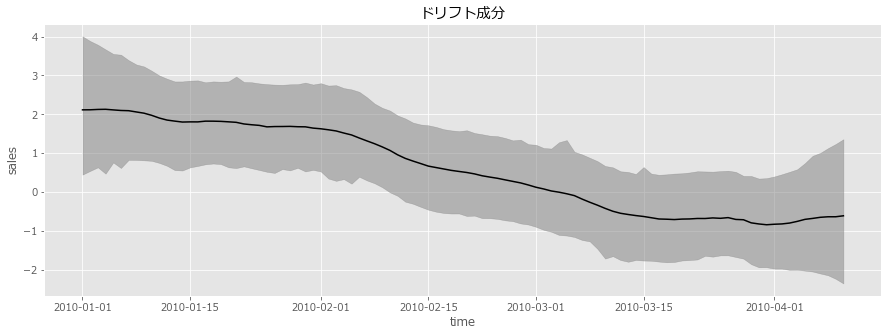

In [26]:
# 描画領域の作成
plt.figure(figsize=(15, 5))
# 50パーセンタイルの値をプロット
plt.plot(result_llt['time'], 
         result_llt['fit'], 
         color='black')
# 2.5-97.5%区間の間を埋める
plt.fill_between(x=result_llt['time'],
                 y1=result_llt['upr'],
                 y2=result_llt['lwr'],
                 color='gray',
                 alpha=0.5)
# x軸ラベルの設定
plt.xlabel('time')
# y軸ラベルの設定
plt.ylabel('sales')
# タイトルの設定
plt.title('ドリフト成分')
# グラフの描画
plt.show()